# 2D Jet POD

In this tutorial we will explore a small dataset provided with this package that contains pressure data of the flow exiting a nozzle (also referred to as a jet).
Cylindrical coordinates (r,x) are used and they are equally spaced. 
In particular, starting from a database of pre computed solutions, we want to:
- extract the POD (coherent in space) modes
- compute the coefficients projecting the data on the POD basis built by gathering the modes
- learn the latent dynamics through a LSTM-based neural network
- predict future coefficients, i.e. the future evolution in time of the flow field
- compare predictions with the actual flow realizations

In detail, the starting dataset consists of 1000 flow realizations which represent the pressure field at different time instant. The time step is 12 hours.

## Loading libraries and data

The dataset is part of the data used for the regression tests that come with this library and is stored into `tests/data/fluidmechanic_data.mat`. The first step to anlyze this dataset is to import the required libraries, including the custom libraries
- 'from pyspod.pod_base import POD_base'
- 'from pyspod.emulation   import Emulation'
- 'import pyspod.utils_weights as utils_weights'
- 'import pyspod.utils as utils'  


In [1]:
# Import libraries
import os
import sys
import h5py
import shutil
import numpy as np
from pathlib import Path

# Current, parent and file paths import sys
CWD = os.getcwd()
sys.path.insert(0, os.path.join(CWD, "../../../../"))

# Import specific libraries
from pyspod.pod_base import POD_base
from pyspod.emulation   import Emulation
import pyspod.utils_weights as utils_weights
import pyspod.utils as utils  

2021-10-26 12:29:46.878476: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The second step conists into importing data from "fluidmechanics_data.mat" located in the folder pysod/test/data and store them in a dictionary. 

In [2]:
file = os.path.join(CWD,'../../../../tests/data','fluidmechanics_data.mat')
variables = ['p']
with h5py.File(file, 'r') as f:
	data_arrays = dict()
	for k, v in f.items():
		data_arrays[k] = np.array(v)

## Define global variables and global parameters

The data are stored in a matrix `X` and, to be suitable to the `PySPOD` library, it must have the following features:
- first dimension must correspond to the number of time snapshots (1000 in our case)
- last dimension should corresponds to the number of variables (1 in our case)
- the remaining dimensions corresponds to the spatial dimensions (20, and 88 in our case, that correspond to radial and axial spatial coordinates).
We note that in the present test case the data matrix `X` used is already in a shape that is suitable to `PySPOD`, as its dimension is:
$$\text{$X$ dimensions} = 1000 \times 20 \times 88 $$

Other global variables and parameters are defined. In detail:
- `nt`: integer, number of snapshots, read from the data_arrays
- `t`: vector containing the time instants at which the flow realizations have been stored
- `x1`: list of coordinate along the x1-axis (in this case x1='r')
- `x2`: list of coordinates along the x2-axis(in this case x2='x')
- `trainingDataRatio`: real, ratio between training data number and total number of snapshots

In the dictionary 'params' the following variables are stored:
- `dt`: time step
- `n_space_dims`: integer, number of space dimensions, in our case 2
- `n_variables`: integer, nr of variables, in our case 1
- `n_modes_save`: integer, number of modes that are taken into account (and stored)
- `savedir`: string, name of the directory where results will be saved
- `normalize_weights` (optional): boolean which activate the normalization of weights by data variance
- `normalize_data` (optional): boolean which normalize data by data variance

**Note that we do not set any parameter for the Weights adopted to compute th einner product in the SPOD calculation. In this case, the algorithm will use automatically uniform weighting (weighting equal 1), and it will prompt a warning stating the use of default uniform weighting.** 

In the dictionary 'params_emulation' the following variables, which allow to define some relevant parameters of a single layer neural network, are stored:
- `network`: string, type of neural network. In the present tutorial 'lstm'
- `epochs`: integer, number of epochs
- `batch_size`: integer, batch size
- `n_seq_in`: integer, dimension of input sequence 
- `n_seq_out`: integer, number of steps to predict
- `n_neurons`: number of neurons in each layer
- `dropout`: value of the dropout
- `savedir`: string, name of the directory where results will be saved

In the present test case we use 60 (`n_seq_in`=60) previous values of the coefficients in order to evaluate the next one (`n_seq_out`=1).

In [3]:
dt = data_arrays['dt'][0,0]
X = data_arrays[variables[0]].T

t = dt * np.arange(0,X.shape[0]); t = t.T
nt = t.shape[0]
x1 = data_arrays['r'].T; x1 = x1[:,0]
x2 = data_arrays['x'].T; x2 = x2[0,:]

trainingDataRatio = 0.8 # ratio between training data number and total number of snapshots
testingDataRatio = (1-trainingDataRatio)

# parameters
params = dict()

# -- required parameters
params['time_step'   	   ] = dt 						# data time-sampling
params['n_space_dims'    ] = 2							# number of spatial dimensions (longitude and latitude)
params['n_variables'     ] = 1							# number of variables
# -- optional parameters
params['normalize_weights'] = False	 			# normalization of weights by data variance
params['normalize_data'   ] = False  			# normalize data by data variance
params['n_modes_save'     ] = 8  		# modes to be saved
params['savedir'          ] = os.path.join(CWD, 'results', Path(file).stem)

params_emulation = dict()

params_emulation['network'     ] = 'lstm' 						# type of network
params_emulation['epochs'      ] = 130 						# number of epochs
params_emulation['batch_size'  ] = 32							# batch size
params_emulation['n_seq_in'    ] = 60							# dimension of input sequence 
params_emulation['n_seq_out'   ] = 1                          # number of steps to predict
params_emulation['n_neurons'   ] = 25                          # number of neurons
params_emulation['dropout'   ] = 0.15                          # dropout
params_emulation['savedir'     ] = os.path.join(CWD, 'results', Path(file).stem)


## Compute POD modes and coefficients 

The following lines of code are used for the initialization of variables. `X_train` and `X_test` are numpy data structures which contain the training set and the testing set respectively; therefore their dimensions are (`nt_train`, 20, 88) and (`nt_test`, 20, 88), being in this test case `nt_train`= $0.8\cdot nt$ and nt_test=$0.2\cdot nt$. 

In [4]:
#  training and testing database definition
nt_train = int(trainingDataRatio * nt)
X_train = X[:nt_train,:,:]
nt_test = nt - nt_train
X_test  = X[nt_train:,:,:]


Once we have loaded the data, defined the required and optional parameters, and allocated the testing and training structures we can perform the analysis. This step is accomplished by calling the `PySPOD` constructor`POD_base(params=params, data_handler=False, variables=variables)` and the `fit` method, `POD_analysis.fit(data=X_train, nt=nt_train)`. 

The `POD_base` constructor takes the following arguments :
  - `params`: must be a dictionary and contains the parameters that we have just defined. 
  - `data_handler`: can be either `False` or a function handler. If it is a function handler, it must hold the function to read the data. The template for the function to read the data must have as first argument the data file, as second and third the time indices through which we will slice the data in time, and as fourth argument a list containing the name of the variables. See our data reader as an example and modify it according to your needs.
  - `variables`: is a list containing our variables. 
The function `fit` returns a reference to the instance object on which it was called, given data and size of this dataset as input.

In [5]:
# SPOD analysis
POD_analysis = POD_base(
params=params, 
data_handler=False, 
variables=variables
)
# fit 
pod = POD_analysis.fit(data=X_train, nt=nt_train)



POD parameters
------------------------------------
Problem size               :  0.010490417480468766 GB. (double)
Time-step                  :  0.2
Time snapshots             :  800
Space dimensions           :  2
Number of variables        :  1
Normalization weights      :  False
Normalization data         :  False
Number of modes to be saved:  8
Results to be saved in     :  /Users/gian/GIT/PySPOD_new/tutorials/fluidmechanics/emulation/jet_2D_POD/results/fluidmechanics_data
------------------------------------



/Users/gian/GIT/PySPOD_new/tutorials/fluidmechanics/emulation/jet_2D_POD/../../../../pyspod/pod_base.py:91: UserWarning: Parameter `weights` not equal to an `numpy.ndarray`.Using default uniform weighting
  warnings.warn(


In the transform function the pressure fluctuations are computed by subtracting the mean field from the snapshots. Then the POD modes are evaluated and the coefficients are obtained by projecting the snapshots representing the pressure fluctuations onto the reduced POD basis obtained by gathering the most significant modes. In details, the `pod.transform` function accept as input
- `data`: dataset on which the analysis is performed
- `nt`: number of snapshots of the dataset 'data'

and it returns a dictionary which contains the following keywords:
- `time_mean`: the average in time of snapshots
- `phi_tilde`: the first most significant modes, i.e. the ones associated to the biggest n_save_modes eigenvalues. These modes identify a reduced basis, significant for the case at hand.
- `coeffs`: the coefficients obtained by projection
- `reconstructed_data`: snapshots reconstructed by superimposing the modes multiplied by the coefficients

The coeffs_test is instead a vector which contains the coefficients which are evaluated by projecting the snapshots of the testing database onto the reduced POD basis previously computed. 

In [6]:
# transform
coeffs_train = pod.transform(data=X_train, nt=nt_train)

X_rearrange_test = np.reshape(X_test[:,:,:], [nt_test,pod.nv*pod.nx])
for i in range(nt_test):
	X_rearrange_test[i,:] = np.squeeze(X_rearrange_test[i,:]) - np.squeeze(coeffs_train['time_mean'])
coeffs_test = np.matmul(np.transpose(coeffs_train['phi_tilde']), X_rearrange_test.T)



coeffs.shape =  (8, 800)


/Users/gian/GIT/PySPOD_new/tutorials/fluidmechanics/emulation/jet_2D_POD/../../../../pyspod/pod_base.py:297: ComplexWarning: Casting complex values to real discards the imaginary part
  phi[:,t] = phi[:,t] / np.sqrt(w[:])


## Learning the latent space dynamics

The following lines are required in order to initialize the data structures needed to train the neural network and to store its output 

In [7]:
# initialization of variables and structures
n_modes = params['n_modes_save'] 
n_feature = coeffs_train['coeffs'].shape[0]

data_train = np.zeros([n_modes,coeffs_train['coeffs'].shape[1]],dtype='double')
data_test = np.zeros([n_modes,coeffs_test.shape[1]],dtype='double')
coeffs_emul = np.zeros([coeffs_test.shape[0],coeffs_test.shape[1]],dtype='double')
coeffs_tmp = np.zeros([n_modes,coeffs_test.shape[1]],dtype='double')


The coefficients previously evaluated can now be used for training a LSTM-based neural network.
The Emulation constructor requires the following parameters:
- `params_emulation`: dict containing the parameters described in the previous sections. They contain all the relevant data for creating a single-layer neural network with Dropout

The neural network is initialized by calling `pod.model_initialize` that requires the data set which the network will be trained with.

In [8]:
# LSTM
pod_emulation = Emulation(params_emulation)

# initialization of the network
pod_emulation.model_initialize(data=data_train)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 25)                3400      
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 208       
Total params: 3,608
Trainable params: 3,608
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


It is a common practice to provide scaled input to the neural network. For this reason a scaler vector is computed by calling the function `utils.compute_normalizationVectorReal`. Three different arguments can be used for defining the `normalizeMethod` variable:
- `localmax`: each coefficient is scaled by its local maximum
- `globalmax`: all the coefficients are scaled by the same value which represent the global maximum
- `None`: no scaling is applied. The output vector contains ones.
Once that the scaling vector is known, the scaling is applied both to the training dataset and to the testing one.

In [9]:
# copy and normalize data 
scaler  = utils.compute_normalizationVectorReal(coeffs_train['coeffs'][:,:], normalizeMethod='localmax')
data_train[:,:] = utils.normalize_dataReal(coeffs_train['coeffs'][:,:], normalizationVec=scaler)
data_test[:,:]  = utils.normalize_dataReal(coeffs_test[:,:], normalizationVec=scaler)

The training of the neural network is carried out by calling the `pod_emulation.model_train` function. The following inputs are requested:
- `idx`: integer, it is an identifier associated to the neural network. Thanks to this idx, more than one network can be trained in the same run and the weights can be stored in different files.
- `data_train`: dataset used for the training
- `data_valid`: dataset used for the validation
- `plotHistory` (otpional): boolean, plot  the trainig history when set to `True`

In [10]:
idx = 0
# train the network
pod_emulation.model_train(idx,
 	data_train=data_train, 
 	data_valid=data_test,
 	plotHistory=False
 	)


extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 739/739 [00:00<00:00, 54382.60it/s]


**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (8, 800)
x.shape =  (739, 60, 8)
y.shape =  (739, 8)
**********************************


extract sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 18947.91it/s]


**********************************
* DATA LAYOUT                    *
**********************************
data_size =  (8, 200)
x.shape =  (139, 60, 8)
y.shape =  (139, 8)
**********************************


2021-10-26 12:30:19.103249: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/130
24/24 [==============================] - 2s 27ms/step - loss: 0.0012 - coeff_determination: -30.8391 - val_loss: 7.8429e-04 - val_coeff_determination: -33.8110
Epoch 2/130
24/24 [==============================] - 0s 13ms/step - loss: 8.6785e-04 - coeff_determination: -7.1956 - val_loss: 5.3612e-04 - val_coeff_determination: -16.5030
Epoch 3/130
24/24 [==============================] - 0s 14ms/step - loss: 6.1650e-04 - coeff_determination: -2.5725 - val_loss: 3.6565e-04 - val_coeff_determination: -9.3300
Epoch 4/130
24/24 [==============================] - 0s 13ms/step - loss: 4.2468e-04 - coeff_determination: -0.5169 - val_loss: 2.3528e-04 - val_coeff_determination: -8.6584
Epoch 5/130
24/24 [==============================] - 0s 14ms/step - loss: 3.0530e-04 - coeff_determination: 0.1556 - val_loss: 1.7677e-04 - val_coeff_determination: -3.7260
Epoch 6/130
24/24 [==============================] - 0s 14ms/step - loss: 2.3900e-04 - coeff_determination: 0.5237 - val_loss: 1.407

24/24 [==============================] - 0s 13ms/step - loss: 8.4596e-05 - coeff_determination: 0.9094 - val_loss: 3.5637e-05 - val_coeff_determination: 0.8343
Epoch 49/130
24/24 [==============================] - 0s 13ms/step - loss: 9.1681e-05 - coeff_determination: 0.8958 - val_loss: 3.4064e-05 - val_coeff_determination: 0.8091
Epoch 50/130
24/24 [==============================] - 0s 13ms/step - loss: 8.3479e-05 - coeff_determination: 0.8987 - val_loss: 3.5754e-05 - val_coeff_determination: 0.7970
Epoch 51/130
24/24 [==============================] - 0s 13ms/step - loss: 8.7311e-05 - coeff_determination: 0.7844 - val_loss: 3.3726e-05 - val_coeff_determination: 0.7567
Epoch 52/130
24/24 [==============================] - 0s 13ms/step - loss: 8.2490e-05 - coeff_determination: 0.7838 - val_loss: 3.3894e-05 - val_coeff_determination: 0.7743
Epoch 53/130
24/24 [==============================] - 0s 13ms/step - loss: 8.1168e-05 - coeff_determination: 0.9102 - val_loss: 3.4206e-05 - val_coe

24/24 [==============================] - 0s 13ms/step - loss: 7.3352e-05 - coeff_determination: 0.7339 - val_loss: 2.5614e-05 - val_coeff_determination: 0.9002
Epoch 96/130
24/24 [==============================] - 0s 14ms/step - loss: 7.4854e-05 - coeff_determination: 0.9011 - val_loss: 2.4533e-05 - val_coeff_determination: 0.8897
Epoch 97/130
24/24 [==============================] - 0s 13ms/step - loss: 7.8011e-05 - coeff_determination: 0.9182 - val_loss: 2.7782e-05 - val_coeff_determination: 0.8317
Epoch 98/130
24/24 [==============================] - 0s 13ms/step - loss: 7.6778e-05 - coeff_determination: 0.9201 - val_loss: 2.5649e-05 - val_coeff_determination: 0.8979
Epoch 99/130
24/24 [==============================] - 0s 13ms/step - loss: 8.0821e-05 - coeff_determination: 0.9127 - val_loss: 2.4458e-05 - val_coeff_determination: 0.9079
Epoch 100/130
24/24 [==============================] - 0s 13ms/step - loss: 7.4643e-05 - coeff_determination: 0.9203 - val_loss: 2.7413e-05 - val_co

After that the neural network has been trained, predictions of the coefficients can be extracted with the aid of the `pod_emulation.model_inference` routine. This receives as inputs:
- `idx`: integer, a value which identify a previously trained neural network (in this case 0, since we have only one neural network)
- `data_input`: data which are used to start the prediction. This array can have an arbitary length. The first `n_seq_in` data are copied in the output vector and used for predicting the next `n_seq_out` steps

The output consists in a vector which has the same dimensions of data_input and contains the predicted scaled coefficients.

The predicted coefficients are then scaled back by calling `utils.denormalize_dataReal.

In [11]:
coeffs_tmp = pod_emulation.model_inference(
	idx, data_input=data_test
	)
coeffs_emul[:,:] = utils.denormalize_dataReal(coeffs_tmp, scaler)

model_inference_real: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:03<00:00, 36.59it/s]
/var/folders/mz/57p2w1h12b915wh_7d77r9wc0000gn/T/ipykernel_71295/4023388671.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs_emul[:,:] = utils.denormalize_dataReal(coeffs_tmp, scaler)


Now we have two distinct types of coefficients which we can use for reconstructing the snaptshots contained in X_test:
- `coeffs_test`: the ones which were obtained by projecting the snapshot on the POD basis
- `emul_coeffs`: the ones which were obtained with the prediction of the LSTM-based neural network.

Fields are reconstructed and stored in a proper numpy array by calling `reconstruct_data` and providing the following input:
- `coeffs`: the coefficients to be used for reconstructing the fields
- `phi_tilde`: a structure containing the modes computed in the `transform` function
- `time_mean`: the mean flow previously computed with the `transform` function

In [12]:
phi_tilde = coeffs_train['phi_tilde']
time_mean = coeffs_train['time_mean']

proj_rec = pod.reconstruct_data(
		coeffs=coeffs_test[:,:], 
		phi_tilde=coeffs_train['phi_tilde'],
		time_mean=coeffs_train['time_mean']
	)

emulation_rec = pod.reconstruct_data(
		coeffs= coeffs_emul, 
		phi_tilde=coeffs_train['phi_tilde'],
		time_mean=coeffs_train['time_mean']
	)


coeffs.shape =  (8, 200)
coeffs.shape =  (8, 200)


## Output 

In the last section of the code, some routines are placed for visulizing some results and computing the errors.

`pod.printErrors`: compute and print L1, L2, and $L_{\inf}$ average norm error for both the learning and the projection error. 
In intput the following input are required:
- `field_test`: "true" solutions, it is a snapshot which belong to the original dataset 
- `field_proj`: fields reconstructed using the coeffs_test, from the comparison between this database and the one containing the true solutions we can evalute the projection error
- `field_emul`: fields reconstructed using the coeffs_emul; from the comparison between this database and the field_proj we can evalute the learning error; from the comparison between this database and the one containing the true solutions we can evalute the total error.
- `n_snaps`: number of snapshots on which the errors are evaluated 
- `n_offset`: offset

`pod.plot_compareTimeSeries`: compare time series, it is here used for comparing actual coefficients and the learned ones. It requires in input: two time series, two labels of the time series, legendLocation(otpional), and the filename (optional)

`pod.generate_2D_subplot`: generate subpolts for visualizing the snapshots. It can show 1, 2 or 3 fields in the same frame. Inputs:
- `title1`: title associated to the first snapshot
- `title2`: title associated to the second snapshot (optional)
- `title3`: title associated to the third snapshot (optional)
- `var1`: 2D array of dimenions $20\times88$ that we want to plot
- `var2`: 2D array of dimenions $20\times88$ that we want to plot (optional)
- `var3`: 2D array of dimenions $20\times88$ that we want to plot (optional)
- `N_round`: number of decimals one wants to keep in the legend (optional)
- `path`: path where one wants to store the results(optional)
- `filename`: name of the file where to save the plot(optional)

Avg L2 error projection vs true solution: 0.00010408893329508038
Avg L2 error lstm prediction vs projection: 1.1225104409145224e-05
Avg L2 error lstm prediction vs true solution: 0.00010472896333363714
Avg L1 error projection vs true solution: 0.002651615270951341
Avg L1 error lstm prediction vs projection: 0.00024181133763099313
Avg L1 error lstm prediction vs true solution: 0.002671110640786702
Avg Linf error projection vs true solution: 0.02768170784823768
Avg Linf error lstm prediction vs projection: 0.0025340864061300385
Avg Linf error lstm prediction vs true solution: 0.027707721491312308


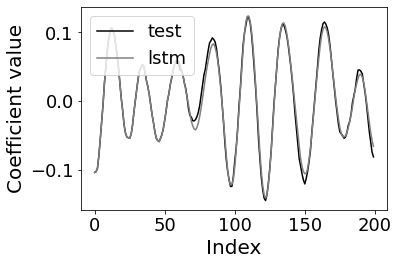

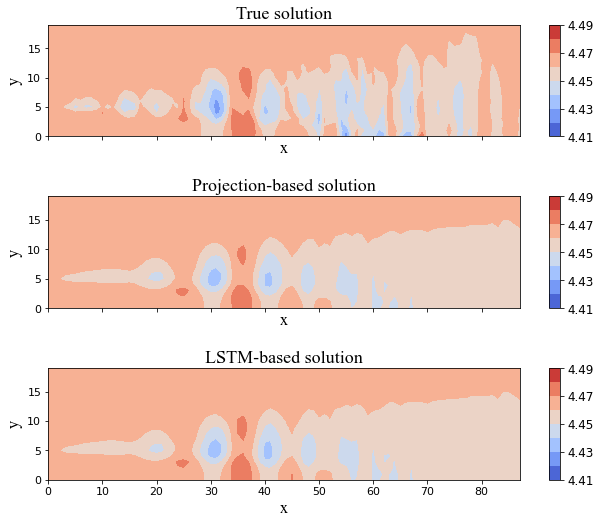

In [13]:
pod.printErrors(field_test=X_test, field_proj=proj_rec, field_emul=emulation_rec, n_snaps = 100, n_offset = 100)

# routines for visualization
pod.plot_compareTimeSeries(
			  serie1= coeffs_test[0,:],
			  serie2= coeffs_emul[0,:],
			  label1='test',
			  label2='lstm',
			  legendLocation = 'upper left',
			  filename=None)

pod.generate_2D_subplot(
	title1='True solution', 
	title2='Projection-based solution', 
	title3='LSTM-based solution',
	var1=X_test[100,:,:], 
	var2=proj_rec[100,:,:,0], 
	var3=emulation_rec[100,:,:,0], 
	N_round=2, path='CWD', filename=None
)

